In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs_v2.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs_v2.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs_v2.h5", "MCSmoothv2")
_df_mc_p4 = pd.read_hdf("data/fitinuts_v2.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs_v2.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("Monojet", "QCD"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp', 'd3kqcdUp', 'dkmixUp',
       'eleEnergyScaleUp', 'eleIdIsoTightUp', 'eleIdIsoVetoUp', 'eleRecoUp',
       'eleTrigUp', 'jerSFUp', 'jesTotalUp', 'lhePdfWeightUp',
       'lheScaleWeightUp', 'lumiUp', 'metTrig0MuSystUp',
       'metTrigReferenceTriggerSystUp', 'metTrigMonojetSystUp',
       'muonIdLooseStatUp', 'muonIdLooseSystUp', 'muonIdTightStatUp',
       'muonIdTightSystUp', 'muonIsoLooseStatUp', 'muonIsoLooseSystUp',
       'muonIsoTightStatUp', 'muonIsoTightSystUp', 'muonPtScaleUp',
       'muonTrigUp', 'photonEnergyScaleUp', 'photonIdLooseUp',
       'photonPixelSeedVetoUp', 'pileupUp', 'prefiringUp', 'tauIdTightUp',
       'tauIdVLooseUp', 'tauPtScaleUp', 'unclustUp', 'alphasDown',
       'btagSFDown', 'd1kewDown', 'd1kqcdDown', 'd2kewwDown', 'd2kewzDown',
       'd2kqcdDown', 'd3kewwDown', 'd3kewzDown', 'd3kqcdDown', 'dkmixDown',
       'eleEnergyScaleDo

In [6]:
region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "WJetsToLNu"): ["lheScaleWeight", "eleTrig", "muonTrig"],
    ("Monojet", "QCD"): [
        "alphas", "btagSF", "d1kew", "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix", "eleEnergyScale", "eleIdIsoTight",
        "eleIdIsoVeto", "eleReco", "eleTrig", "jerSF", "jesTotal", "unclust", "lhePdfWeight", "lheScaleWeight", "lumi", "metTrig0MuSyst",
        "metTrigReferenceTriggerSyst", "metTrigMonojetSyst", "muonIdLooseStat", "muonIdLooseSyst", "muonIsoLooseStat", "muonIsoLooseSyst", "muonIdTightSyst",
        "muonIdTightStat", "muonIsoTightSyst", "muonIsoTightStat", "muonPtScale", "muonTrig", "photonEnergyScale", "photonIdLoose", "photonPixelSeedVeto",
        "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "tauPtScale",
    ],
    ("Monojet", "MinorBkgs"): ["eleTrig", "muonTrig"],
    ("SingleMuon", "WJetsToLNu"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("SingleMuon", "QCD"): ["muonTrig", "eleTrig"],
    ("SingleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("SingleElectron", "WJetsToLNu"): ["lheScaleWeight", "muonTrig"],
    ("SingleElectron", "MinorBkgs"): ["muonTrig"],
    ("DoubleMuon", "DYJetsToLL"): ["lheScaleWeight", "muonTrig", "eleTrig"],
    ("DoubleMuon", "MinorBkgs"): ["muonTrig", "eleTrig"],
    ("DoubleElectron", "DYJetsToLL"): ["lheScaleWeight", "muonTrig"],
    ("DoubleElectron", "MinorBkgs"): ["muonTrig"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
vjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("SingleElectron", "MinorBkgs"): minor_bkgs,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleMuon", "MinorBkgs"): minor_bkgs,
    ("DoubleElectron", "DYJetsToLL"): vjets,
    ("DoubleElectron", "MinorBkgs"): minor_bkgs,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
vjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("Monojet", "ZJetsToNuNu"): vjets,
    ("Monojet", "WJetsToLNu"): vjets,
    ("SingleMuon", "WJetsToLNu"): vjets,
    ("SingleElectron", "WJetsToLNu"): vjets,
    ("DoubleMuon", "DYJetsToLL"): vjets,
    ("DoubleElectron", "DYJetsToLL"): vjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("Monojet", "QCD"): qcd,
    ("Monojet", "MinorBkgs"): minors,
    ("SingleMuon", "WJetsToLNu"): ["jerSF"],
    ("SingleMuon", "QCD"): qcd,
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleElectron", "MinorBkgs"): minors,
    ("DoubleMuon", "MinorBkgs"): minors,
    ("DoubleElectron", "MinorBkgs"): minors,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_flat.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass

## Symmetrize

In [10]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "tauIdTightUp"
tdf_do["variation"] = "tauIdTightDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "tauIdTightDown"),:] = tdf_do

In [11]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "unclustUp"
tdf_do["variation"] = "unclustDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:] = tdf_do

In [12]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jerSFUp"
tdf_do["variation"] = "jerSFDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:] = tdf_do

In [13]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "jesTotalUp"
tdf_do["variation"] = "jesTotalDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:] = tdf_do

In [14]:
tdf = (
    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
)/2.
tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
tdf_up = tdf_nom + tdf
tdf_do = tdf_nom - tdf
tdf_up["variation"] = "eleTrigUp"
tdf_do["variation"] = "eleTrigDown"

tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigUp"),:] = tdf_up
_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "eleTrigDown"),:] = tdf_do

## Split JES uncertainties

In [15]:
bin_min = _df_data.index.get_level_values("bin_min").unique().values
bin_max = _df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [16]:
#for idx, bval in enumerate(bin_min):
#    nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#    var_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#    var_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#    
#    selection = nom.index.get_level_values("bin_min")==bval
#    var_up.loc[selection,:] = nom.loc[selection,:]
#    var_down.loc[selection,:] = nom.loc[selection,:]
#    
#    var_up["variation"] = "jesTotalB{}Up".format(idx)
#    var_down["variation"] = "jesTotalB{}Down".format(idx)
#    
#    order = ["region", "process", "variation", "bin_min", "bin_max"]
#    var_up = var_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#    var_down = var_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#    
#    _df_mc = pd.concat([_df_mc, var_down, var_up], axis=0, sort=True)
#    _df_mc.tail(5)

In [17]:
#nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""), :].reset_index("variation", drop=True)
#var_low_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_low_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#var_high_up = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"), :].reset_index("variation", drop=True)
#var_high_down = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"), :].reset_index("variation", drop=True)
#
#selection = nom.index.get_level_values("bin_min")>1000.
#var_low_up.loc[selection,:] = nom.loc[selection,:]
#var_low_down.loc[selection,:] = nom.loc[selection,:]
#
#var_high_up.loc[~selection,:] = nom.loc[~selection,:]
#var_high_down.loc[~selection,:] = nom.loc[~selection,:]
#
#var_low_up["variation"] = "jesTotalLowUp"
#var_low_down["variation"] = "jesTotalLowDown"
#var_high_up["variation"] = "jesTotalHighUp"
#var_high_down["variation"] = "jesTotalHighDown"
#
#order = ["region", "process", "variation", "bin_min", "bin_max"]
#var_low_up = var_low_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_low_down = var_low_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_up = var_high_up.set_index("variation", append=True).reorder_levels(order).sort_index()
#var_high_down = var_high_down.set_index("variation", append=True).reorder_levels(order).sort_index()
#
#_df_mc = pd.concat([_df_mc, var_low_down, var_low_up, var_high_down, var_high_up], axis=0, sort=True)
#_df_mc.tail(5)

In [18]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "SingleMuon"),
    ("MET", "DoubleMuon"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [19]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## QCD corrections

In [20]:
df_mc.head(5)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928

In [21]:
df_qcd = pd.read_hdf("data/qcd_estimation.h5", "QCDCorrection")
print(df_mc.loc[("Monojet", "QCD", ""),:].head(5))
df_mc.loc[("Monojet", "QCD", ""), "sum_w"] = df_mc.loc[("Monojet", "QCD", "", pd.IndexSlice[:]), "sum_w"]*df_qcd["correction"]
df_mc.loc[("Monojet", "QCD", ""), "sum_ww"] = df_mc.loc[("Monojet", "QCD", "", pd.IndexSlice[:]), "sum_ww"]*df_qcd["correction"]**2
print(df_mc.loc[("Monojet", "QCD", ""),:].head(5))

                       sum_w         sum_ww
bin_min bin_max                            
200.0   220.0    1507.879983  870197.869365
220.0   250.0    1081.495254  239040.729627
250.0   280.0     178.490955    1689.528372
280.0   310.0     410.587219   96974.765275
310.0   340.0      48.495099     499.555464
                       sum_w        sum_ww
bin_min bin_max                           
200.0   220.0    1663.878681  1.059565e+06
220.0   250.0    1234.382422  3.114025e+05
250.0   280.0     211.843679  2.379929e+03
280.0   310.0     505.988166  1.472749e+05
310.0   340.0      61.969241  8.157186e+02


In [22]:
nom = df_mc.loc[("Monojet", "QCD", ""), "sum_w"].copy()
nom_ww = df_mc.loc[("Monojet", "QCD", ""), "sum_ww"].copy()

new_variations = []
new_variations_ww = []
for idx in range(df_qcd.shape[0]):
    vari_up = nom.copy()
    vari_do = nom.copy()
    vari_up.iloc[idx] = (nom*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_do.iloc[idx] = (nom*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_up = vari_up.to_frame()
    vari_do = vari_do.to_frame()
    vari_up["variation"] = "qcdSystB{}Up".format(idx)
    vari_do["variation"] = "qcdSystB{}Down".format(idx)
    vari_up = vari_up.set_index("variation", append=True)
    vari_do = vari_do.set_index("variation", append=True)
    
    vari_ww_up = nom_ww.copy()
    vari_ww_do = nom_ww.copy()
    vari_ww_up.iloc[idx] = (nom_ww*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_ww_do.iloc[idx] = (nom_ww*df_qcd.eval("correction*(1+rel_unc_up)")).iloc[idx]
    vari_ww_up = vari_ww_up.to_frame()
    vari_ww_do = vari_ww_do.to_frame()
    vari_ww_up["variation"] = "qcdSystB{}Up".format(idx)
    vari_ww_do["variation"] = "qcdSystB{}Down".format(idx)
    vari_ww_up = vari_ww_up.set_index("variation", append=True)
    vari_ww_do = vari_ww_do.set_index("variation", append=True)
    
    new_variations.extend([vari_up, vari_do])
    new_variations_ww.extend([vari_ww_up, vari_ww_do])
    
df_out = pd.concat([pd.concat(new_variations), pd.concat(new_variations_ww)], axis=1)
df_out["region"] = "Monojet"
df_out["process"] = "QCD"
df_out = df_out.set_index(["region", "process"], append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()

df_mc = pd.concat([df_mc, df_out], sort=True)
print(df_mc.head(5))

                                                       sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928


## GStar contribution

In [23]:
df_kzkg = pd.read_hdf("data/gstar_prediction.h5", "GStarPredictions").set_index("parameter").stack()
df_kzkg.index.names = ["parameter", "variation"]
value = df_kzkg.loc[(pd.IndexSlice[:],"value")]
relvals = df_kzkg.divide(value)-1.

selection = df_kzkg.index.get_level_values("variation")!="value"
df_kzkg.loc[selection] = relvals.loc[selection]

dyll = df_mc.loc[(pd.IndexSlice[:], "DYJetsToLL"), :].reset_index("process", drop=True)
levels = df_mc.index.names

zll = dyll.copy(deep=True)
zll.loc[:,"sum_w"] = zll["sum_w"]*df_kzkg.loc[("kz", "value")]
zll.loc[:,"sum_ww"] = zll["sum_ww"]*(df_kzkg.loc[("kz", "value")]**2)
zll["process"] = "ZJetsToLL"
zll = zll.set_index("process", append=True).reorder_levels(levels).sort_index()

# variations
variations = []
zll_nom = zll.loc[(pd.IndexSlice[:], "ZJetsToLL", ""), :].reset_index("variation", drop=True)

for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*(1 + df_kzkg.loc[("kz", "stat{}".format(updown))])
    zll_vari.loc[:,"sum_ww"] = zll_vari["sum_ww"]*((1 + df_kzkg.loc[("kz", "stat{}".format(updown))])**2)
    zll_vari["variation"] = "kzStat{}".format(updown)
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(zll_vari)
    
for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*(1 + df_kzkg.loc[("kz", "genIdReweight"+updown)])
    zll_vari.loc[:,"sum_ww"] = zll_vari["sum_ww"]*((1 + df_kzkg.loc[("kz", "genIdReweight"+updown)])**2)
    zll_vari["variation"] = "genIdReweight"+updown
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(zll_vari)
    
for updown in ["Up", "Down"]:
    zll_vari = zll_nom.copy(deep=True)
    zll_pdf = zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown), :].reset_index("variation", drop=True)
    zll_vari.loc[:,"sum_w"] = zll_vari["sum_w"]*df_kzkg.loc[("kz", "lhePdfWeight"+updown)]
    zll_vari["variation"] = "lhePdfWeight"+updown
    zll_vari = zll_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown),"sum_w"] = (
        zll.loc[(pd.IndexSlice[:], "ZJetsToLL", "lhePdfWeight"+updown),"sum_w"]
        + zll_vari["sum_w"]
    )

gstar = dyll.copy(deep=True)
gstar.loc[:,"sum_w"] = gstar["sum_w"]*df_kzkg.loc[("kg", "value")]
gstar.loc[:,"sum_ww"] = gstar["sum_ww"]*(df_kzkg.loc[("kg", "value")]**2)
gstar["process"] = "GStarJetsToLL"
gstar = gstar.set_index("process", append=True).reorder_levels(levels).sort_index()

gstar_nom = gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", ""),:].reset_index("variation", drop=True)
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*(1 + df_kzkg.loc[("kg", "stat{}".format(updown))])
    gstar_vari.loc[:,"sum_ww"] = gstar_vari["sum_ww"]*((1 + df_kzkg.loc[("kg", "stat{}".format(updown))])**2)
    gstar_vari["variation"] = "kgStat{}".format(updown)
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(gstar_vari)
    
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*(1 + df_kzkg.loc[("kg", "genIdReweight"+updown)])
    gstar_vari.loc[:,"sum_ww"] = gstar_vari["sum_ww"]*((1 + df_kzkg.loc[("kg", "genIdReweight"+updown)])**2)
    gstar_vari["variation"] = "genIdReweight"+updown
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    variations.append(gstar_vari)
    
for updown in ["Up", "Down"]:
    gstar_vari = gstar_nom.copy(deep=True)
    gstar_pdf = gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown), :].reset_index("variation", drop=True)
    gstar_vari.loc[:,"sum_w"] = gstar_vari["sum_w"]*df_kzkg.loc[("kz", "lhePdfWeight"+updown)]
    gstar_vari["variation"] = "lhePdfWeight"+updown
    gstar_vari = gstar_vari.set_index("variation", append=True).reorder_levels(levels).sort_index()
    gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown),"sum_w"] = (
        gstar.loc[(pd.IndexSlice[:], "GStarJetsToLL", "lhePdfWeight"+updown),"sum_w"]
        + gstar_vari["sum_w"]
    )
        
df_mc = pd.concat([df_mc, zll, gstar]+variations, axis=0, sort=True)

## Run fits

In [24]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [25]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'qcdSystB8Down', 'qcdSystB8Up', 'qcdSystB9Down', 'qcdSystB9Up',
       'kzStatUp', 'kzStatDown', 'genIdReweightUp', 'genIdReweightDown',
       'kgStatUp', 'kgStatDown'],
      dtype='object', name='variation', length=155)

In [26]:
df_kzkg = pd.read_hdf("data/gstar_prediction.h5", "GStarPredictions").set_index("parameter").stack()
df_kzkg.index.names = ["parameter", "variation"]
value = df_kzkg.loc[(pd.IndexSlice[:],"value")]
relvals = df_kzkg.divide(value)-1.

selection = df_kzkg.index.get_level_values("variation")!="value"
df_kzkg.loc[selection] = relvals.loc[selection]
df_kzkg

parameter  variation         
kz         value                 1.016459
           statUp                0.000825
           statDown             -0.000824
           genIdReweightUp       0.014404
           genIdReweightDown    -0.014404
           lhePdfWeightUp        0.022977
           lhePdfWeightDown     -0.022977
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
kg         value                 0.015040
           statUp                0.001487
           statDown             -0.001485
           genIdReweightUp       0.134813
           genIdReweightDown    -0.134813
           lhePdfWeightUp        0.024335
           lhePdfWeightDown     -0.024335
           lheScaleWeightUp      0.000000
           lheScaleWeightDown    0.000000
dtype: float64

In [27]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":        ["ZJetsToNuNu", "WJetsToLNu", "QCD", "MinorBkgs"],
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "DoubleMuon":     ["DYJetsToLL", "MinorBkgs"],
    "DoubleElectron": ["DYJetsToLL", "MinorBkgs"],
}

kz = (
    "p['kz']*"+
    "np.power("+
        "(1 + (p['kzStat']>=0)*p['kzStat_valUp'] + (p['kzStat']<0)*p['kzStat_valDown']),"+
        "p['kzStat'],"+
    ")*np.power("+
        "(1 + (p['lhePdfWeight']>=0)*p['kzPdf_valUp'] + (p['lhePdfWeight']<0)*p['kzPdf_valDown']),"+
        "p['lhePdfWeight'],"+
    ")*np.power("+
        "(1 + (p['lheScaleWeight']>=0)*p['kzScale_valUp'] + (p['lheScaleWeight']<0)*p['kzScale_valDown']),"+
        "p['lheScaleWeight'],"+
    ")*np.power("+
        "(1 + (p['genIdReweight']>=0)*p['kzGenIdReweight_valUp'] + (p['genIdReweight']<0)*p['kzGenIdReweight_valDown']),"+
        "p['genIdReweight'],"+
    ")"
)
kg = (
    "p['kg']*"+
    "np.power("+
        "(1 + (p['kgStat']>=0)*p['kgStat_valUp'] + (p['kgStat']<0)*p['kgStat_valDown']),"+
        "p['kgStat'],"+
    ")*np.power("+
        "(1 + (p['lhePdfWeight']>=0)*p['kgPdf_valUp'] + (p['lhePdfWeight']<0)*p['kgPdf_valDown']),"+
        "p['lhePdfWeight'],"+
    ")*np.power("+
        "(1 + (p['lheScaleWeight']>=0)*p['kgScale_valUp'] + (p['lheScaleWeight']<0)*p['kgScale_valDown']),"+
        "p['lheScaleWeight'],"+
    ")*np.power("+
        "(1 + (p['genIdReweight']>=0)*p['kgGenIdReweight_valUp'] + (p['genIdReweight']<0)*p['kgGenIdReweight_valDown']),"+
        "p['genIdReweight'],"+
    ")"
)

kzkg_params = [
    {"name": "kz",                      "value": df_kzkg.loc[("kz", "value")],              "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat_valUp",            "value": df_kzkg.loc[("kz", "statUp")],             "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat_valDown",          "value": df_kzkg.loc[("kz", "statDown")],           "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzPdf_valUp",             "value": df_kzkg.loc[("kz", "lhePdfWeightUp")],     "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzPdf_valDown",           "value": df_kzkg.loc[("kz", "lhePdfWeightDown")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzScale_valUp",           "value": df_kzkg.loc[("kz", "lheScaleWeightUp")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzScale_valDown",         "value": df_kzkg.loc[("kz", "lheScaleWeightDown")], "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzGenIdReweight_valUp",   "value": df_kzkg.loc[("kz", "genIdReweightUp")],    "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzGenIdReweight_valDown", "value": df_kzkg.loc[("kz", "genIdReweightDown")],  "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kg",                      "value": df_kzkg.loc[("kg", "value")],              "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgStat_valUp",            "value": df_kzkg.loc[("kg", "statUp")],             "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgStat_valDown",          "value": df_kzkg.loc[("kg", "statDown")],           "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgPdf_valUp",             "value": df_kzkg.loc[("kg", "lhePdfWeightUp")],     "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgPdf_valDown",           "value": df_kzkg.loc[("kg", "lhePdfWeightDown")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgScale_valUp",           "value": df_kzkg.loc[("kg", "lheScaleWeightUp")],   "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgScale_valDown",         "value": df_kzkg.loc[("kg", "lheScaleWeightDown")], "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgGenIdReweight_valUp",   "value": df_kzkg.loc[("kg", "genIdReweightUp")],    "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kgGenIdReweight_valDown", "value": df_kzkg.loc[("kg", "genIdReweightDown")],  "limit": (None, None), "fixed": True, "constraint": "free"},
    {"name": "kzStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "kgStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "genIdReweight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
]

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJets",       "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rZJetsToNuNu", "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",  "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
    ] + kzkg_params + [
        {"name": "metTrig0MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "qcdSystB{}".format(idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for idx in range(len(bin_min))
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-10., 10.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"):  "x, w, p: p['rZJets']*p['rZJetsToNuNu']",
        ("Monojet",        "QCD"):          "x, w, p: (1-0.2*p['rZJets']*p['rZJetsToNuNu'])", # 20% correlation in the QCD corrections with Zvv signal
        ("Monojet",        "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):   "x, w, p: p['rWJetsToLNu']",
        ("DoubleMuon",     "DYJetsToLL"):   "x, w, p: ({kz})*p['rZJets'] + (1-({kz})-({kg}))*np.sqrt(p['rZJets']) + ({kg})".format(kz=kz, kg=kg),
        ("DoubleElectron", "DYJetsToLL"):   "x, w, p: ({kz})*p['rZJets'] + (1-({kz})-({kg}))*np.sqrt(p['rZJets']) + ({kg})".format(kz=kz, kg=kg),
    }
}


In [28]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":        ["ZJetsToNuNu", "WJetsToLNu", "QCD", "MinorBkgs"],
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "DoubleMuon":     ["DYJetsToLL", "ZJetsToLL", "GStarJetsToLL", "MinorBkgs"],
    "DoubleElectron": ["DYJetsToLL", "ZJetsToLL", "GStarJetsToLL", "MinorBkgs"],
}

[
    {"name": "kzStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "kgStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "genIdReweight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
]

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJets",       "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rZJetsToNuNu", "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",  "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        
        {"name": "kzStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "kgStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "genIdReweight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig0MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "qcdSystB{}".format(idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for idx in range(len(bin_min))
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-10., 10.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"):   "x, w, p: p['rZJets']*p['rZJetsToNuNu']",
        ("Monojet",        "QCD"):           "x, w, p: (1-0.2*(p['rZJets']*p['rZJetsToNuNu']-1))", # 20% correlation in the QCD corrections with Zvv signal
        ("Monojet",        "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("DoubleMuon",     "DYJetsToLL"):    "x, w, p: np.sqrt(p['rZJets'])",
        ("DoubleMuon",     "ZJetsToLL"):     "x, w, p: p['rZJets']-np.sqrt(p['rZJets'])",
        ("DoubleMuon",     "GStarJetsToLL"): "x, w, p: 1.-np.sqrt(p['rZJets'])",
        ("DoubleElectron", "DYJetsToLL"):    "x, w, p: np.sqrt(p['rZJets'])",
        ("DoubleElectron", "ZJetsToLL"):     "x, w, p: p['rZJets']-np.sqrt(p['rZJets'])",
        ("DoubleElectron", "GStarJetsToLL"): "x, w, p: 1.-np.sqrt(p['rZJets'])",
    }
}


## Asimov fit

In [47]:
model_asimov = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer_asimov = model_asimov.fit(asimov=True, migrad=False, minos=False)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [48]:
minimizer_asimov.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 2289                    |   Ncalls=21351 (21351 total)   |
| EDM = 1.66E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJets                      |   1.000   |   0.007   |            |            |    0    |   10    |       |
| 1  | rZJetsToNuNu                |   1.000   |   0.008   |            |            |    0    |   10    |       |
| 2  | rWJetsToLNu                 |   1.000   |   0.007   |            |            |    0    |   10    |       |
| 3  | kzStat                      |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 4  | kgStat                      |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 5  | genIdReweight               |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 6  | metTrig0MuSyst              |   0.000   |   0.560   |            |            |   -5    |    5    |       |
| 7  | metTrig1MuSyst              |   0.000   |   0.707   |            |            |   -5    |    5    |       |
| 8  | metTrig2MuSyst              |   0.000   |   0.858   |            |            |   -5    |    5    |       |
| 9  | metTrigReferenceTriggerSyst |   0.000   |   0.940   |            |            |   -5    |    5    |       |
| 10 | qcdSystB0                   |    0.0    |    0.9    |            |            |   -5    |    5    |       |
| 11 | qcdSystB1                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 12 | qcdSystB2                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 13 | qcdSystB3                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 14 | qcdSystB4                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 15 | qcdSystB5                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 16 | qcdSystB6                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 17 | qcdSystB7                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 18 | qcdSystB8                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 19 | qcdSystB9                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 20 | qcdSystB10                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 21 | qcdSystB11                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 22 | qcdSystB12                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 23 | qcdSystB13                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 24 | qcdSystB14                  |    0.0    |    1.0    |            |            |   -5

In [63]:
pd.set_option('display.max_rows', None)
df = pd.DataFrame(impacts_asimov)

df.loc[df["valid"].isna(), "valid"] = True
df.set_index(["param", "poi"]).to_hdf(
    "fit_results.h5", "ImpactsAsimov",
    format='table', append=False,
    complevel=9, complib='zlib',
)

In [51]:
impacts_asimov = dftools.fitting.run_impacts(
    [p for p in minimizer.parameters if not minimizer.fixed[p] and "mcstat" not in p],
    "rZJetsToNuNu",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
    params_guess=dict(minimizer.values),
)

2019-10-01 18:03:06,307 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191001_180306_27ic9kg7


2019-10-01 18:03:11,337 - pysge.submitter - INFO - Submitted 9965515.1-72:1


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


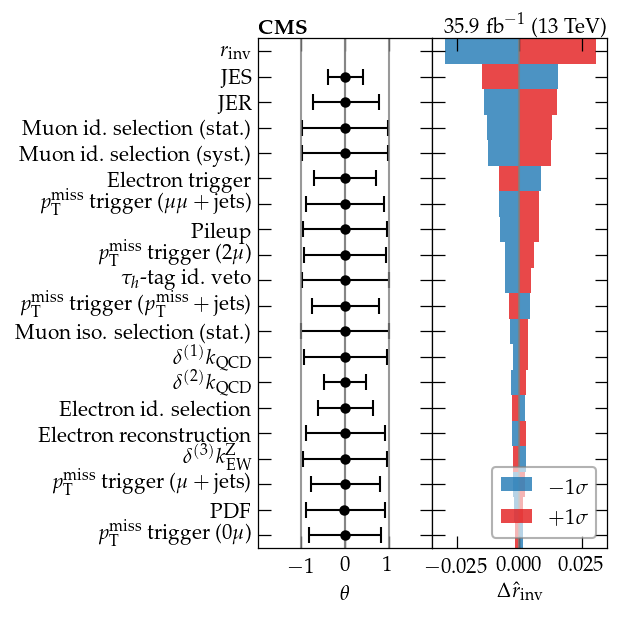

In [66]:
df = pd.DataFrame(impacts_asimov)
#print(df)
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
    #~df.index.get_level_values("param").str.contains("mcstat")
    df.index.get_level_values("param").isin([
        "rZJetsToNuNu",
        "unclust", "muonIdTightStat", "muonIdTightSyst", "jesTotal", "jerSF", "eleTrig", "metTrigDoubleMuonSyst", "metTrig2MuSyst", "tauIdVLoose", "pileup",
        "d1kqcd", "metTrigSingleMuonSyst", "metTrigMonojetSyst", "eleReco", "prefiring", "muonIsoTightStat", "metTrig1MuSyst", "lhePdfWeight", "d3kqcd",
        "d2kqcd", "d3kewz", "eleIdIsoTight", "dkmix", "lumi", "d2keww", "metTrigReferenceTriggerSyst", "muonIsoTightSyst", "d2kewz", "d1kew", "genIdReweight",
        "d3keww", "btagSF", "lheScaleWeight", "metTrig0MuSyst", "eleIdIsoVeto", "kzStat", "muonIdVetoStat", "kgStat", "tauIdTight", "muonIdLooseSyst",
        "photonPixelSeedVeto", "muonIsoLooseStat", "photonIdLoose", "muonIsoLooseSyst",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-20:]
#print(tdf)
#tdf.loc[("rZJetsToNuNu", "rZJets"),"param_value"] = np.nan
tdf.loc[("rZJetsToNuNu", "rZJetsToNuNu"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rZJetsToNuNu"] = r'$r_{\mathrm{inv}}$'
conv["metTrigMonojetSyst"] = r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger ($p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$)'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_{\mathrm{inv}}$')
ax[1].set_xlim(-0.035, 0.035)
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,4.5)
fig.align_labels(ax)
#fig.savefig("plots/impacts.pdf", format='pdf', bbox_inches='tight')

In [71]:
scan_asimov = dftools.fitting.run_profile_likelihood(
    "rZJetsToNuNu", np.linspace(0.8, 1.2, 101),
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G"),
    nll_class=dftools.fitting.NLLModel,
    params_guess=dict(minimizer.values),
)

2019-10-01 18:39:13,809 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191001_183913_hy83pnup


2019-10-01 18:39:21,343 - pysge.submitter - INFO - Submitted 9965562.1-101:1


(0.9, 1.15)

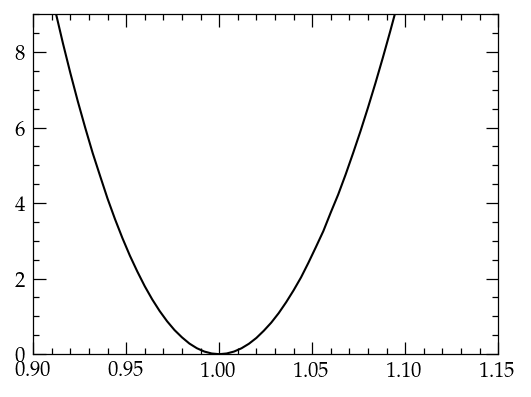

In [86]:
df_scan = pd.DataFrame(scan_asimov)

fig, ax = plt.subplots(
    figsize=(4,3), dpi=150,
)

ax.plot(
    df_scan["parameter_value"],
    df_scan["dnll"], color='black',
)
ax.set_ylim(0., 9.)
ax.set_xlim(0.9, 1.15)

In [89]:
df_scan.set_index("parameter").to_hdf(
    "fit_results.h5", "ScanAsimov",
    format='table', append=False,
    complevel=9, complib='zlib',
)

## Observed fit

In [49]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [50]:
df = pd.read_hdf("fit_results.h5", "ImpactsObserved")
for r in df.reset_index().iterrows():
    minimizer.values[r[1]["param"]] = r[1]["param_value"]

In [51]:
%time minimizer.migrad(ncall=100_000)

CPU times: user 2min 24s, sys: 1.39 s, total: 2min 26s
Wall time: 2min 24s


------------------------------------------------------------------
| FCN = 2457                    |   Ncalls=28653 (28653 total)   |
| EDM = 2.1E-05 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJets                      |   1.04    |   0.07    |            |            |    0    |   10    |       |
| 1  | rZJetsToNuNu                |   1.02    |   0.03    |            |            |    0    |   10    |       |
| 2  | rWJetsToLNu                 |   1.16    |   0.08    |            |            |    0    |   10    |       |
| 3  | kzStat                      |  -0.000   |   0.993   |            |            |   -5    |    5    |       |
| 4  | kgStat                      |   0.000   |   0.993   |            |            |   -5    |    5    |       |
| 5  | genIdReweight               |  -0.000   |   0.993   |            |            |   -5    |    5    |       |
| 6  | metTrig0MuSyst              |    0.6    |    0.8    |            |            |   -5    |    5    |       |
| 7  | metTrig1MuSyst              |   -0.29   |    0.87   |            |            |   -5    |    5    |       |
| 8  | metTrig2MuSyst              |   0.18    |   0.94    |            |            |   -5    |    5    |       |
| 9  | metTrigReferenceTriggerSyst |   0.25    |   0.99    |            |            |   -5    |    5    |       |
| 10 | qcdSystB0                   | 0.001E-1  | 1.232E-1  |            |            |   -5    |    5    |       |
| 11 | qcdSystB1                   | 0.002E-1  | 1.572E-1  |            |            |   -5    |    5    |       |
| 12 | qcdSystB2                   |   0.000   |   0.711   |            |            |   -5    |    5    |       |
| 13 | qcdSystB3                   | 0.003E-1  | 2.555E-1  |            |            |   -5    |    5    |       |
| 14 | qcdSystB4                   |   0.000   |   0.729   |            |            |   -5    |    5    |       |
| 15 | qcdSystB5                   |   0.000   |   0.443   |            |            |   -5    |    5    |       |
| 16 | qcdSystB6                   |   0.000   |   0.521   |            |            |   -5    |    5    |       |
| 17 | qcdSystB7                   |   0.000   |   1.301   |            |            |   -5    |    5    |       |
| 18 | qcdSystB8                   |   0.000   |   1.049   |            |            |   -5    |    5    |       |
| 19 | qcdSystB9                   |   0.000   |   0.930   |            |            |   -5    |    5    |       |
| 20 | qcdSystB10                  |   0.000   |   0.899   |            |            |   -5    |    5    |       |
| 21 | qcdSystB11                  |   0.000   |   0.974   |            |            |   -5    |    5    |       |
| 22 | qcdSystB12                  |   0.000   |   1.230   |            |            |   -5    |    5    |       |
| 23 | qcdSystB13                  |   0.000   |   1.079   |            |            |   -5    |    5    |       |
| 24 | qcdSystB14                  |   0.000   |   1.060   |            |            |   -5

In [52]:
results_impacts = dftools.fitting.run_impacts(
    [p for p in minimizer.parameters if not minimizer.fixed[p] and "mcstat" not in p],
    "rZJetsToNuNu",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=dict(minimizer.values),
)

2019-10-02 00:49:03,686 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191002_004903_cjszxzi7


2019-10-02 00:49:08,463 - pysge.submitter - INFO - Submitted 9968714.1-72:1


In [54]:
df = pd.DataFrame(results_impacts)

df.loc[df["valid"].isna(), "valid"] = True
df.set_index(["param", "poi"]).to_hdf(
    "fit_results.h5", "ImpactsObserved",
    format='table', append=False,
    complevel=9, complib='zlib',
)

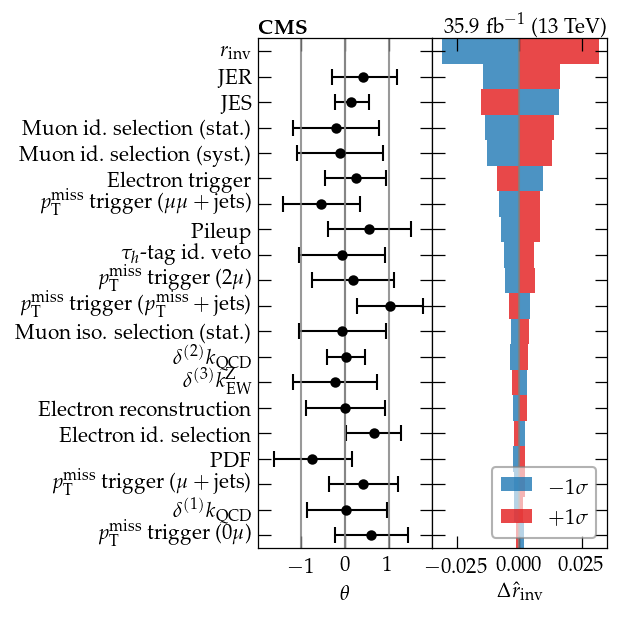

In [55]:
df = pd.DataFrame(results_impacts)
#df = pd.read_hdf("fit_results.h5", "ImpactsObserved").reset_index()
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
    #~df.index.get_level_values("param").str.contains("mcstat")
    df.index.get_level_values("param").isin([
        "rZJetsToNuNu",
        "unclust", "muonIdTightStat", "muonIdTightSyst", "jesTotal", "jerSF", "eleTrig", "metTrigDoubleMuonSyst", "metTrig2MuSyst", "tauIdVLoose", "pileup",
        "d1kqcd", "metTrigSingleMuonSyst", "metTrigMonojetSyst", "eleReco", "prefiring", "muonIsoTightStat", "metTrig1MuSyst", "lhePdfWeight", "d3kqcd",
        "d2kqcd", "d3kewz", "eleIdIsoTight", "dkmix", "lumi", "d2keww", "metTrigReferenceTriggerSyst", "muonIsoTightSyst", "d2kewz", "d1kew", "genIdReweight",
        "d3keww", "btagSF", "lheScaleWeight", "metTrig0MuSyst", "eleIdIsoVeto", "kzStat", "muonIdVetoStat", "kgStat", "tauIdTight", "muonIdLooseSyst",
        "photonPixelSeedVeto", "muonIsoLooseStat", "photonIdLoose", "muonIsoLooseSyst",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-20:]
tdf.loc[("rZJetsToNuNu", "rZJetsToNuNu"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rZJetsToNuNu"] = r'$r_{\mathrm{inv}}$'
conv["metTrigMonojetSyst"] = r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger ($p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$)'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_{\mathrm{inv}}$')
ax[1].set_xlim(-0.035, 0.035)
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,4.5)
fig.align_labels(ax)
fig.savefig("plots/impacts.pdf", format='pdf', bbox_inches='tight')

In [72]:
scan_observed = dftools.fitting.run_profile_likelihood(
    "rZJetsToNuNu", np.linspace(0.8, 1.2, 101),
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    fit_kwargs=dict(migrad=False, minos=False),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G"),
    nll_class=dftools.fitting.NLLModel,
    params_guess=dict(minimizer.values),
)

2019-10-01 18:55:17,131 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191001_185517_jrpj7cpk


2019-10-01 18:55:24,464 - pysge.submitter - INFO - Submitted 9965572.1-101:1


(0.9, 1.15)

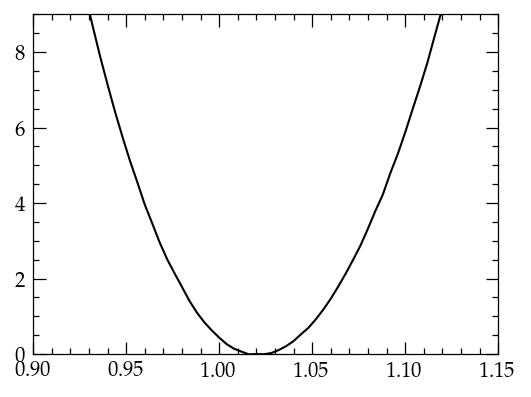

In [91]:
df_scan = pd.DataFrame(scan_observed)

fig, ax = plt.subplots(
    figsize=(4,3), dpi=150,
)

ax.plot(
    df_scan["parameter_value"],
    df_scan["dnll"], color='black',
)
ax.set_ylim(0., 9.)
ax.set_xlim(0.9, 1.15)

In [92]:
df_scan.set_index("parameter").to_hdf(
    "fit_results.h5", "ScanObserved",
    format='table', append=False,
    complevel=9, complib='zlib',
)

## Profile likelihood scan

In [41]:
scan = dftools.fitting.run_profile_likelihood(
    "rZJetsToNuNu", np.linspace(0.8, 1.2, 101),
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G"),
    nll_class=dftools.fitting.NLLModel,
    params_guess=dict(minimizer.values),
)

2019-10-01 04:02:33,955 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191001_040233__u_mdmt8


2019-10-01 04:02:40,553 - pysge.submitter - INFO - Submitted 9961040.1-101:1


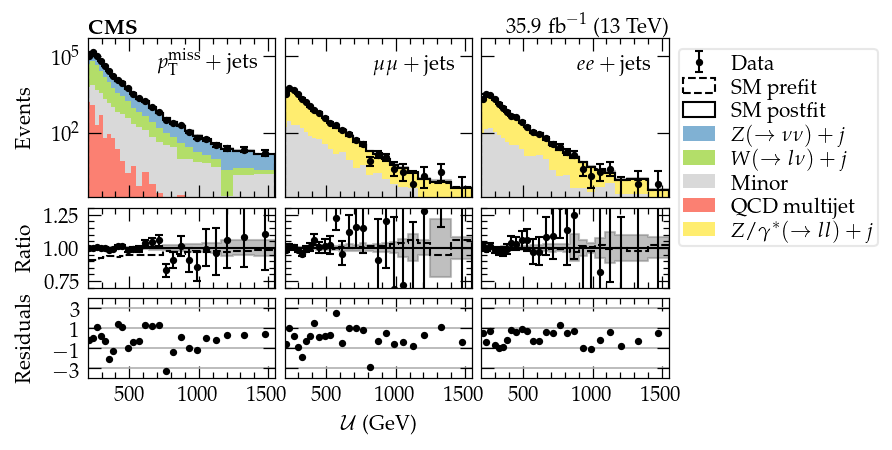

In [45]:
import numdifftools
fig, ax = plt.subplots(
    figsize=(5, 3), dpi=150,
    nrows=3, ncols=3,
    sharex='col', sharey='row',
    gridspec_kw={
        "height_ratios": (2,1,1),
        "hspace": 0.1, "wspace": 0.05,
    },
)

ax[0,0].set_yscale('log')
ax[0,0].set_ylim(0.3, 5e5)
ax[1,0].set_ylim(0.7, 1.3)
ax[2,0].set_ylim(-4, 4)

def pred_func(_ps, region):
    _ps[:3] = np.maximum(_ps[:3], 0.)
    model.set_parameters(_ps)
    try:
        results = model.predictions(region)["prediction"]
    except RuntimeError:
        print(_ps)
        model.set_parameters(minimizer.np_values())
        raise RuntimeError
    model.set_parameters(minimizer.np_values())
    return results

for idx, region, procs in [
    (0, "Monojet", ["QCD", "MinorBkgs", "WJetsToLNu", "ZJetsToNuNu"]),
    (1, "DoubleMuon", ["MinorBkgs", "DYJetsToLL"]),
    (2, "DoubleElectron", ["MinorBkgs", "DYJetsToLL"]),
]:
    bin_min, bin_max = model.bins[region]
    ax[(0,idx)].set_xlim(bin_min[0], bin_max[-1])
    
    # data
    data = model.data[region]
    data_lower, data_upper = dftools.stats.poisson_interval(data)
    ax[(0,idx)].errorbar(
        (bin_min + bin_max)/2., data,
        yerr=(data-data_lower, data_upper-data),
        fmt='o', color='black', label="Data",
    )
    
    # mc
    mc = [model.prediction(region).loc[p] for p in procs]
    colours = [dftools.draw.process_colours.get(p, 'blue') for p in procs]
    labels = [dftools.draw.process_names.get(p, p) for p in procs]
    ax[(0,idx)].hist(
        [bin_min]*len(mc), bins=list(bin_min)+[bin_max[-1]],
        weights=mc, color=colours, label=labels, stacked=True,
    )
        
    # sm - postfit
    sm = model.predictions(region)["prediction"]
    ax[(0,idx)].hist(
        bin_min, bins=list(bin_min)+[bin_max[-1]],
        weights=sm, histtype='step', color='black',
        label="SM postfit",
    )
    bf_params = minimizer.np_values()
    cov = minimizer.np_matrix(skip_fixed=False)
    jac = numdifftools.Jacobian(lambda _arg: pred_func(_arg, region))(bf_params)
    err = scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(
        np.matmul(jac, np.matmul(cov, jac.T)).diagonal()
    )
    ax[(0,idx)].fill_between(
        list(bin_min)+[bin_max[-1]],
        list(sm-err)+[(sm-err)[-1]],
        list(sm+err)+[(sm+err)[-1]],
        step='post', color='gray', alpha=0.5,
    )
    
    # sm - prefit
    old_params = copy.deepcopy(model.parameters)
    model.set_parameters(model.param_inits)
    sm_prefit = model.predictions(region)["prediction"]
    model.set_parameters(minimizer.np_values())
    ax[(0,idx)].hist(
        bin_min, bins=list(bin_min)+[bin_max[-1]],
        weights=sm_prefit, histtype='step', color='black', ls='--',
        label="SM prefit",
    )
    
    # ratio
    ax[(1,idx)].errorbar(
        (bin_min + bin_max)/2., data/sm,
        yerr=((data-data_lower)/sm, (data_upper-data)/sm),
        fmt='o', color='black',
    )
    ax[(1,idx)].hist(
        bin_min, bins=list(bin_min)+[bin_max[-1]],
        weights=np.ones_like(sm), histtype='step', color='black',
    )
    ax[(1,idx)].hist(
        bin_min, bins=list(bin_min)+[bin_max[-1]],
        weights=sm_prefit/sm, histtype='step', color='black', ls='--',
    )
    ax[(1,idx)].fill_between(
        list(bin_min)+[bin_max[-1]],
        list(1-err/sm)+[(1-err/sm)[-1]],
        list(1+err/sm)+[(1+err/sm)[-1]],
        step='post', color='gray', alpha=0.5,
    )
    
    # pulls
    diff = data - sm
    sigma = np.sqrt(err**2 + np.where(diff>=0., data-data_lower, data_upper-data)**2)
    ax[(2,idx)].plot(
        (bin_min + bin_max)/2., diff/sigma, 'o', color='black',
    )
    
ax[2,0].set_yticks([-3, -1, 1, 3], minor=False)
ax[2,1].set_yticks([-3, -1, 1, 3], minor=False)
ax[2,2].set_yticks([-3, -1, 1, 3], minor=False)
ax[2,0].grid(which="major", axis="y")
ax[2,1].grid(which="major", axis="y")
ax[2,2].grid(which="major", axis="y")
ax[2,0].tick_params(axis='y', which='minor', left=False, right=False)
ax[2,1].tick_params(axis='y', which='minor', left=False, right=False)
ax[2,2].tick_params(axis='y', which='minor', left=False, right=False)

ax[0,0].set_ylabel('Events')
ax[1,0].set_ylabel('Ratio')
ax[2,0].set_ylabel('Residuals')
ax[2,1].set_xlabel('$\mathcal{U}$ (GeV)')

h1, l1 = ax[0,0].get_legend_handles_labels()
h2, l2 = ax[0,1].get_legend_handles_labels()
ax[0,2].legend(
    h1[::-1]+[h2[1]], l1[::-1]+[l2[1]],
    loc=2, bbox_to_anchor=(1,1),
    fancybox=True, edgecolor="#d9d9d9",
    labelspacing=0.1, borderpad=0.2,
)

ax[0,0].text(0.9, 0.9, r'$p_{\mathrm{T}}^{\mathrm{miss}}+\mathrm{jets}$', ha='right', va='top', transform=ax[0,0].transAxes)
ax[0,1].text(0.9, 0.9, r'$\mu\mu+\mathrm{jets}$', ha='right', va='top', transform=ax[0,1].transAxes)
ax[0,2].text(0.9, 0.9, r'$ee+\mathrm{jets}$', ha='right', va='top', transform=ax[0,2].transAxes)

ax[0,0].text(0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,2].text(1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom', transform=ax[0,2].transAxes)
fig.align_labels(ax)
fig.savefig("plots/postfit_sr.pdf", format="pdf", bbox_inches='tight')
pass

## View parameter effects

bin_min  bin_max
200.0    220.0      27245.772275
220.0    250.0      43010.129453
250.0    280.0      33856.076231
280.0    310.0      22655.182136
310.0    340.0      15295.262818
340.0    370.0      10227.904801
370.0    400.0       6892.667472
400.0    430.0       4523.120057
430.0    470.0       3822.202830
470.0    510.0       2355.062080
510.0    550.0       1528.721277
550.0    590.0       1013.192556
590.0    640.0        767.608810
640.0    690.0        467.370663
690.0    740.0        304.139227
740.0    790.0        201.661673
790.0    840.0        127.661775
840.0    900.0        102.193366
900.0    960.0         64.492656
960.0    1020.0        40.031660
1020.0   1090.0        31.800116
1090.0   1160.0        18.065813
1160.0   1250.0        12.545811
1250.0   1400.0        10.620290
1400.0   1550.0         7.289474
dtype: float64


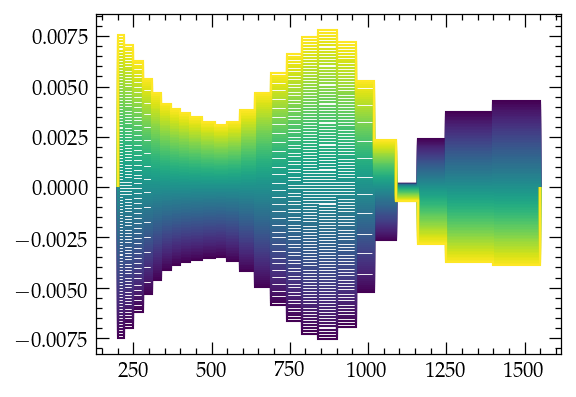

In [43]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleMuon"
proc = "WJetsToLNu"
nuis = "pileup"

nom = model.prediction(region).loc[proc]
print(nom)
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.prediction(region).loc[proc]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

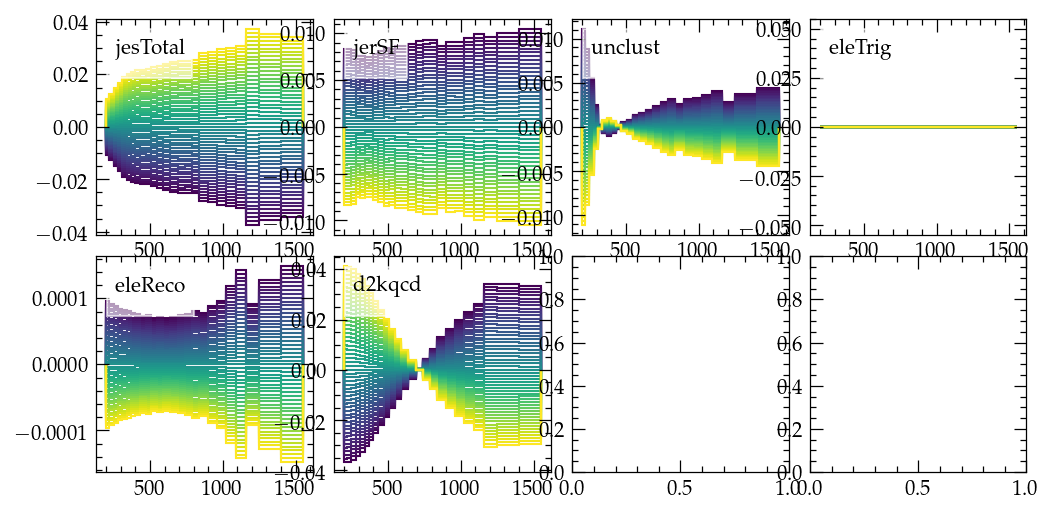

In [36]:
parameters = [
    #'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    #'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    #'d2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
    "jesTotal", "jerSF", "unclust", "eleTrig", "eleReco", "d2kqcd",
]
region = "Monojet"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = (len(parameters)-1)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


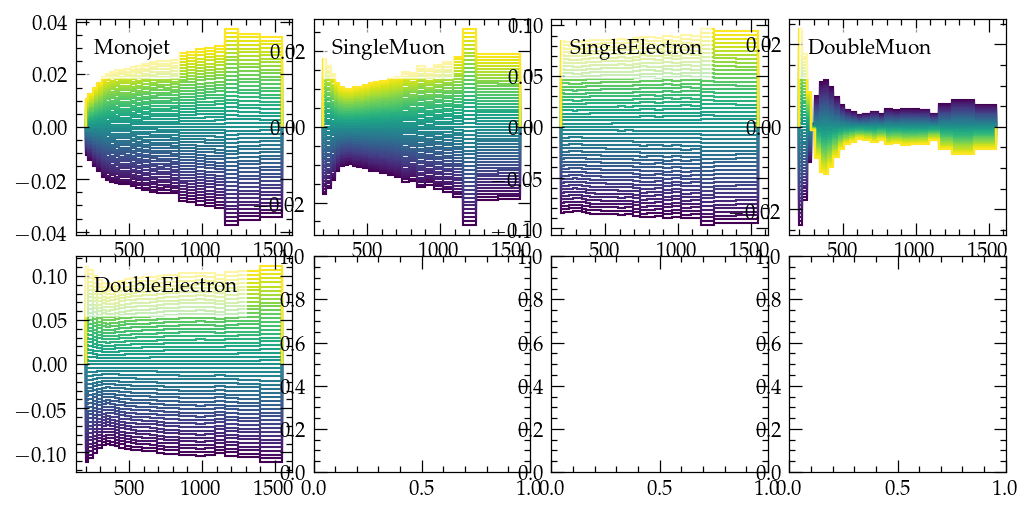

In [73]:
regions = ["Monojet", "SingleMuon", "SingleElectron", "DoubleMuon", "DoubleElectron"]
nuisance = "jesTotal"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(regions)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, region in enumerate(regions):
    model.set_parameters(mod_params)
    nom = model.predictions(region)["prediction"].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(regions)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=region)


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


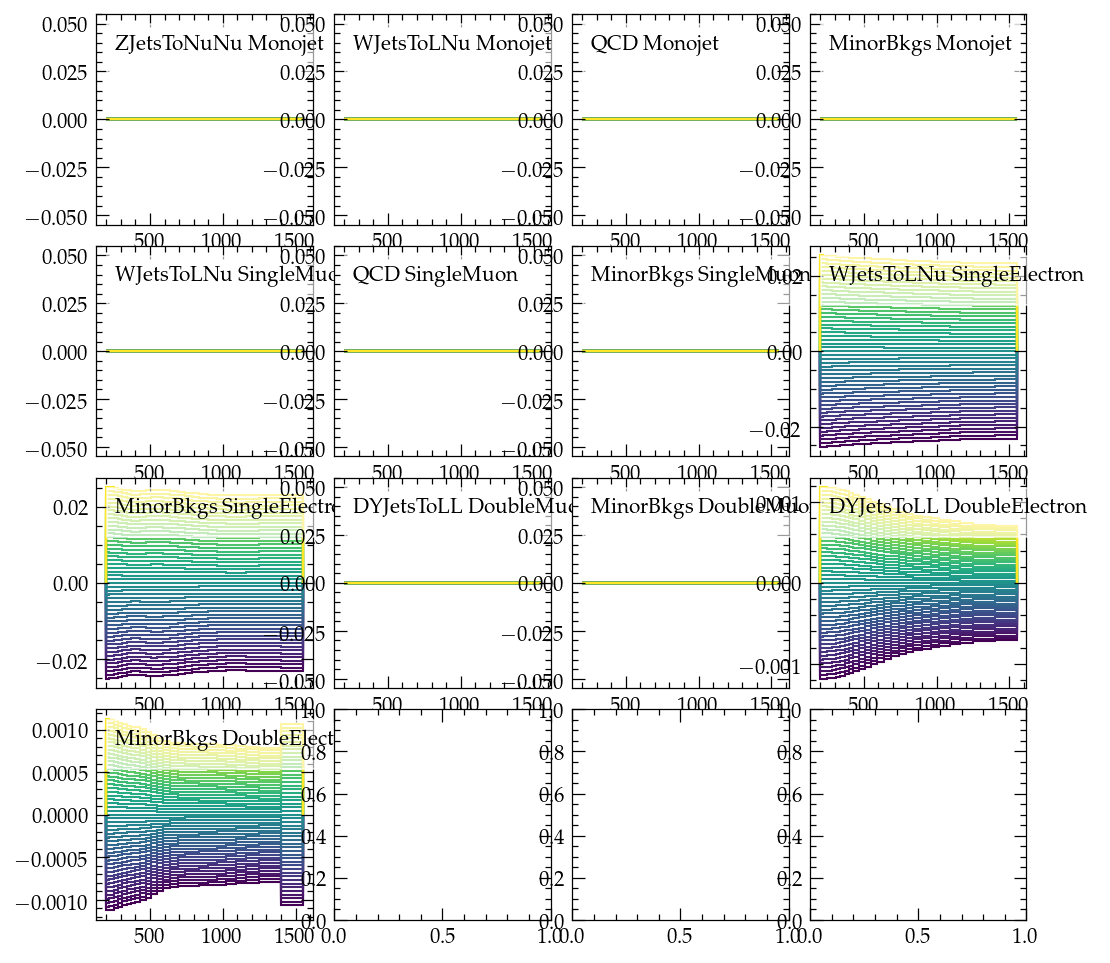

In [72]:
region_procs = [
    ("Monojet", "ZJetsToNuNu"),
    ("Monojet", "WJetsToLNu"),
    ("Monojet", "QCD"),
    ("Monojet", "MinorBkgs"),
    ("SingleMuon", "WJetsToLNu"),
    ("SingleMuon", "QCD"),
    ("SingleMuon", "MinorBkgs"),
    ("SingleElectron", "WJetsToLNu"),
    ("SingleElectron", "MinorBkgs"),
    ("DoubleMuon", "DYJetsToLL"),
    ("DoubleMuon", "MinorBkgs"),
    ("DoubleElectron", "DYJetsToLL"),
    ("DoubleElectron", "MinorBkgs"),
]
nuisance = "eleTrig"

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
bins = model.bins[region]

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(region_procs)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, (region, process) in enumerate(region_procs):
    model.set_parameters(mod_params)
    nom = model.prediction(region).loc[(process)].values
    
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[nuisance] = theta
        model.set_parameters(tparams)
        pred = model.prediction(region).loc[(process)].values
    
        row = idx//4
        col = idx%4
        if len(region_procs)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=process+" "+region)


In [95]:
bins = (bin_min, bin_max)

regions = {
    "Monojet":        ["ZJetsToNuNu", "WJetsToLNu", "QCD", "MinorBkgs"],
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
    "DoubleMuon":     ["DYJetsToLL", "ZJetsToLL", "GStarJetsToLL", "MinorBkgs"],
    "DoubleElectron": ["DYJetsToLL", "ZJetsToLL", "GStarJetsToLL", "MinorBkgs"],
}

[
    {"name": "kzStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "kgStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    {"name": "genIdReweight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
]

config ={
    "regions": regions,
    "parameters": [
        {"name": "rZJetsToLL",   "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rZJetsToNuNu", "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLNu",  "value": 1., "limit": (0., 10.), "fixed": False, "constraint": "free"},
        
        {"name": "kzStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "kgStat",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "genIdReweight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig0MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig2MuSyst",              "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "qcdSystB{}".format(idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for idx in range(len(bin_min))
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-10., 10.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("Monojet",        "ZJetsToNuNu"):   "x, w, p: p['rZJetsToNuNu']",
        ("Monojet",        "QCD"):           "x, w, p: (1-0.2*(p['rZJetsToNuNu']-1))", # 20% correlation in the QCD corrections with Zvv signal
        ("Monojet",        "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("SingleMuon",     "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):    "x, w, p: p['rWJetsToLNu']",
        ("DoubleMuon",     "DYJetsToLL"):    "x, w, p: np.sqrt(p['rZJetsToLL'])",
        ("DoubleMuon",     "ZJetsToLL"):     "x, w, p: p['rZJetsToLL']-np.sqrt(p['rZJetsToLL'])",
        ("DoubleMuon",     "GStarJetsToLL"): "x, w, p: 1.-np.sqrt(p['rZJetsToLL'])",
        ("DoubleElectron", "DYJetsToLL"):    "x, w, p: np.sqrt(p['rZJetsToLL'])",
        ("DoubleElectron", "ZJetsToLL"):     "x, w, p: p['rZJetsToLL']-np.sqrt(p['rZJetsToLL'])",
        ("DoubleElectron", "GStarJetsToLL"): "x, w, p: 1.-np.sqrt(p['rZJetsToLL'])",
    }
}


In [96]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)

In [97]:
%time minimizer.migrad(ncall=100_000)

CPU times: user 2min 11s, sys: 1.21 s, total: 2min 13s
Wall time: 2min 11s


------------------------------------------------------------------
| FCN = 2460                    |   Ncalls=25735 (25735 total)   |
| EDM = 0.000136 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJetsToLL                  |   1.04    |   0.04    |            |            |    0    |   10    |       |
| 1  | rZJetsToNuNu                |   1.07    |   0.04    |            |            |    0    |   10    |       |
| 2  | rWJetsToLNu                 |   1.16    |   0.05    |            |            |    0    |   10    |       |
| 3  | kzStat                      |   0.000   |   0.993   |            |            |   -5    |    5    |       |
| 4  | kgStat                      |  -0.000   |   0.993   |            |            |   -5    |    5    |       |
| 5  | genIdReweight               |   0.000   |   1.001   |            |            |   -5    |    5    |       |
| 6  | metTrig0MuSyst              |    1.3    |    0.7    |            |            |   -5    |    5    |       |
| 7  | metTrig1MuSyst              |   -0.03   |    0.86   |            |            |   -5    |    5    |       |
| 8  | metTrig2MuSyst              |    0.3    |    0.9    |            |            |   -5    |    5    |       |
| 9  | metTrigReferenceTriggerSyst |    0.4    |    1.0    |            |            |   -5    |    5    |       |
| 10 | qcdSystB0                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 11 | qcdSystB1                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 12 | qcdSystB2                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 13 | qcdSystB3                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 14 | qcdSystB4                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 15 | qcdSystB5                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 16 | qcdSystB6                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 17 | qcdSystB7                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 18 | qcdSystB8                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 19 | qcdSystB9                   |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 20 | qcdSystB10                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 21 | qcdSystB11                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 22 | qcdSystB12                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 23 | qcdSystB13                  |    0.0    |    1.0    |            |            |   -5    |    5    |       |
| 24 | qcdSystB14                  |    0.0    |    1.0    |            |            |   -5

In [98]:
results_impacts = dftools.fitting.run_impacts(
    [p for p in minimizer.parameters if not minimizer.fixed[p] and "mcstat" not in p],
    "rZJetsToNuNu",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=dict(minimizer.values),
)

2019-10-01 19:38:40,533 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191001_193840_ycvrhvmk


2019-10-01 19:38:44,930 - pysge.submitter - INFO - Submitted 9965644.1-72:1


## Stat unc

In [68]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [69]:
df = pd.read_hdf("fit_results.h5", "ImpactsObserved")
for r in df.reset_index().iterrows():
    minimizer.values[r[1]["param"]] = r[1]["param_value"]

In [70]:
%time minimizer.migrad(ncall=100_000)

CPU times: user 2min 23s, sys: 1.6 s, total: 2min 25s
Wall time: 2min 23s


------------------------------------------------------------------
| FCN = 2457                    |   Ncalls=27497 (27497 total)   |
| EDM = 1.06E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJets                      |   1.04    |   0.07    |            |            |    0    |   10    |       |
| 1  | rZJetsToNuNu                |   1.02    |   0.03    |            |            |    0    |   10    |       |
| 2  | rWJetsToLNu                 |   1.16    |   0.08    |            |            |    0    |   10    |       |
| 3  | kzStat                      |  -0.000   |   0.993   |            |            |   -5    |    5    |       |
| 4  | kgStat                      |   0.000   |   0.993   |            |            |   -5    |    5    |       |
| 5  | genIdReweight               |  -0.000   |   0.993   |            |            |   -5    |    5    |       |
| 6  | metTrig0MuSyst              |    0.6    |    0.8    |            |            |   -5    |    5    |       |
| 7  | metTrig1MuSyst              |   -0.29   |    0.87   |            |            |   -5    |    5    |       |
| 8  | metTrig2MuSyst              |   0.18    |   0.94    |            |            |   -5    |    5    |       |
| 9  | metTrigReferenceTriggerSyst |   0.25    |   0.99    |            |            |   -5    |    5    |       |
| 10 | qcdSystB0                   | 0.000E-1  | 1.224E-1  |            |            |   -5    |    5    |       |
| 11 | qcdSystB1                   | 0.000E-1  | 1.539E-1  |            |            |   -5    |    5    |       |
| 12 | qcdSystB2                   |  -0.000   |   0.707   |            |            |   -5    |    5    |       |
| 13 | qcdSystB3                   | 0.001E-1  | 2.537E-1  |            |            |   -5    |    5    |       |
| 14 | qcdSystB4                   |  -0.000   |   0.729   |            |            |   -5    |    5    |       |
| 15 | qcdSystB5                   |   0.000   |   0.442   |            |            |   -5    |    5    |       |
| 16 | qcdSystB6                   |   0.000   |   0.520   |            |            |   -5    |    5    |       |
| 17 | qcdSystB7                   |   0.000   |   1.299   |            |            |   -5    |    5    |       |
| 18 | qcdSystB8                   |   0.000   |   1.048   |            |            |   -5    |    5    |       |
| 19 | qcdSystB9                   |  -0.000   |   0.930   |            |            |   -5    |    5    |       |
| 20 | qcdSystB10                  |  -0.000   |   0.899   |            |            |   -5    |    5    |       |
| 21 | qcdSystB11                  |  -0.000   |   0.974   |            |            |   -5    |    5    |       |
| 22 | qcdSystB12                  |  -0.000   |   1.230   |            |            |   -5    |    5    |       |
| 23 | qcdSystB13                  |  -0.000   |   1.080   |            |            |   -5    |    5    |       |
| 24 | qcdSystB14                  |  -0.000   |   1.060   |            |            |   -5

In [72]:
print(minimizer.values["rZJetsToNuNu"])
minimizer.minos("rZJetsToNuNu")
print(minimizer.merrors[("rZJetsToNuNu", 1.)])
print(minimizer.merrors[("rZJetsToNuNu", -1.)])

1.020976078398152
0.032028814925901906
-0.031086165594996502


In [73]:
params = copy.deepcopy(minimizer.parameters)
for p in params:
    if p not in ("rZJets", "rZJetsToNuNu", "rWJetsToLNu"):
        minimizer.fixed[p] = True

In [74]:
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 2457                    |    Ncalls=20 (34011 total)     |
| EDM = 7.69E-13 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|    | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0  | rZJets                      |   1.038   |   0.006   |            |            |    0    |   10    |       |
| 1  | rZJetsToNuNu                |   1.021   |   0.006   |   -0.031   |    0.032   |    0    |   10    |       |
| 2  | rWJetsToLNu                 |   1.155   |   0.002   |            |            |    0    |   10    |       |
| 3  | kzStat                      |  -0.000   |   0.993   |            |            |   -5    |    5    |  yes  |
| 4  | kgStat                      |   0.000   |   0.993   |            |            |   -5    |    5    |  yes  |
| 5  | genIdReweight               |  -0.000   |   0.993   |            |            |   -5    |    5    |  yes  |
| 6  | metTrig0MuSyst              |    0.6    |    0.8    |            |            |   -5    |    5    |  yes  |
| 7  | metTrig1MuSyst              |   -0.29   |    0.87   |            |            |   -5    |    5    |  yes  |
| 8  | metTrig2MuSyst              |   0.18    |   0.94    |            |            |   -5    |    5    |  yes  |
| 9  | metTrigReferenceTriggerSyst |   0.25    |   0.99    |            |            |   -5    |    5    |  yes  |
| 10 | qcdSystB0                   | 0.000E-1  | 1.224E-1  |            |            |   -5    |    5    |  yes  |
| 11 | qcdSystB1                   | 0.000E-1  | 1.539E-1  |            |            |   -5    |    5    |  yes  |
| 12 | qcdSystB2                   |  -0.000   |   0.707   |            |            |   -5    |    5    |  yes  |
| 13 | qcdSystB3                   | 0.001E-1  | 2.537E-1  |            |            |   -5    |    5    |  yes  |
| 14 | qcdSystB4                   |  -0.000   |   0.729   |            |            |   -5    |    5    |  yes  |
| 15 | qcdSystB5                   |   0.000   |   0.442   |            |            |   -5    |    5    |  yes  |
| 16 | qcdSystB6                   |   0.000   |   0.520   |            |            |   -5    |    5    |  yes  |
| 17 | qcdSystB7                   |   0.000   |   1.299   |            |            |   -5    |    5    |  yes  |
| 18 | qcdSystB8                   |   0.000   |   1.048   |            |            |   -5    |    5    |  yes  |
| 19 | qcdSystB9                   |  -0.000   |   0.930   |            |            |   -5    |    5    |  yes  |
| 20 | qcdSystB10                  |  -0.000   |   0.899   |            |            |   -5    |    5    |  yes  |
| 21 | qcdSystB11                  |  -0.000   |   0.974   |            |            |   -5    |    5    |  yes  |
| 22 | qcdSystB12                  |  -0.000   |   1.230   |            |            |   -5    |    5    |  yes  |
| 23 | qcdSystB13                  |  -0.000   |   1.080   |            |            |   -5    |    5    |  yes  |
| 24 | qcdSystB14                  |  -0.000   |   1.060   |            |            |   -5

In [75]:
print(minimizer.values["rZJetsToNuNu"])
minimizer.minos("rZJetsToNuNu")
print(minimizer.merrors[("rZJetsToNuNu", 1.)])
print(minimizer.merrors[("rZJetsToNuNu", -1.)])

1.0209761344752566
0.006141466156904078
-0.006096954862988615


In [64]:
scan_stat = dftools.fitting.run_profile_likelihood(
    "rZJetsToNuNu", np.linspace(0.8, 1.2, 101),
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    fit_kwargs=dict(migrad=False, minos=False),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G"),
    nll_class=dftools.fitting.NLLModel,
    params_guess=dict(minimizer.values),
    fixed_params=[
        p for p in params
        if p not in ("rZJets", "rZJetsToNuNu", "rWJetsToLNu")
    ],
)

2019-10-02 01:22:30,020 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/final_fit/_ccsp_temp/tpd_20191002_012230_h_e19yyo


2019-10-02 01:22:37,789 - pysge.submitter - INFO - Submitted 9968717.1-101:1


In [67]:
pd.DataFrame(scan_stat).set_index("parameter").to_hdf(
    "fit_results.h5", "ScanStat",
    format="table", append=True,
    complevel=9, complib='zlib',
)